##### 범주형 변수를 실제로 인코딩하고 중요 피쳐를 뽑아보는 파일

In [59]:
import pandas as pd
file_path = "data.csv"
df = pd.read_csv(file_path)

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

# 컬럼 드랍

In [61]:
cols_to_drop = [col for col in df.columns if col.startswith("서울_")]
df = df.drop(columns=cols_to_drop)

In [62]:
df = df[["영화명", "장르", "국적", "감독", "배급사", "배우", "누적관객수", "총매출액", "상영일수"]]

In [63]:
df.columns

Index(['영화명', '장르', '국적', '감독', '배급사', '배우', '누적관객수', '총매출액', '상영일수'], dtype='object')

# 범주형 변수 인코딩

## 장르

In [64]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

df_copy = df.copy()
df_copy['장르_list'] = df_copy['장르'].fillna('').str.split(',')
df_copy['장르_list'] = df_copy['장르_list'].apply(lambda lst: [s.strip() for s in lst if s.strip() != ''])
mlb = MultiLabelBinarizer(sparse_output=False)
genre_ohe = mlb.fit_transform(df_copy['장르_list'])
genre_ohe_df = pd.DataFrame(genre_ohe, columns=[f"장르_{c}" for c in mlb.classes_], index=df_copy.index)
df_ohe = pd.concat([df_copy, genre_ohe_df], axis=1).drop(columns=['장르_list'])

In [ ]:
df_ohe

In [66]:
import pandas as pd
import numpy as np

# 원본 df를 복사
df_te = df_ohe.copy()

# 1) '장르'를 리스트로 변환
df_te['장르_list'] = df_te['장르'].fillna('').str.split(',').apply(lambda lst: [s.strip() for s in lst if s.strip() != ''])

# 2) explode로 장르별 한 행씩 분리
df_exploded = df_te.explode('장르_list')
df_exploded = df_exploded[df_exploded['장르_list'] != '']

# 3) 장르별 평균 상영일수 계산
genre_mean = df_exploded.groupby('장르_list')['상영일수'].mean().to_dict()

# 4) 전체 평균 상영일수(장르가 없거나 매핑이 안 되는 경우 사용)
global_mean = df_exploded['상영일수'].mean()

# 5) 영화별 장르 target encoding: 각 영화의 장르 평균 상영일수의 평균
def encode_genres(lst):
    if not lst:
        return global_mean
    vals = [genre_mean.get(g, global_mean) for g in lst]
    return np.mean(vals)

df_te['genre_target_enc'] = df_te['장르_list'].apply(encode_genres)

# 6) 필요 시 중간 컬럼 제거
df_te = df_te.drop(columns=['장르_list'])


In [ ]:
df_te

## 국적

In [68]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

df = df_te.copy()
df['국적_list'] = df['국적'].fillna('').str.split(',').apply(lambda lst: [s.strip() for s in lst if s.strip() != ''])
df_exploded = df.explode('국적_list')

# '기타'를 카운팅에서 제외하고 상위 15개 국가 선택
filtered = df_exploded[df_exploded['국적_list'] != '기타']
counts = filtered['국적_list'].value_counts()
top15 = counts.nlargest(15).index.tolist()

def map_country_list(lst):
    mapped = [c if c in top15 else 'Other' for c in lst]
    if any(c in top15 for c in mapped):
        return [c for c in mapped if c in top15]
    return ['Other']

df['국적_list'] = df['국적_list'].apply(map_country_list)
mlb = MultiLabelBinarizer(sparse_output=False)
nat_ohe = mlb.fit_transform(df['국적_list'])
nat_ohe_df = pd.DataFrame(nat_ohe, columns=[f"국적_{c}" for c in mlb.classes_], index=df.index)
df_result = pd.concat([df, nat_ohe_df], axis=1).drop(columns=['국적_list'])


In [69]:
df_result.columns

Index(['영화명', '장르', '국적', '감독', '배급사', '배우', '누적관객수', '총매출액', '상영일수', '장르_SF',
       '장르_가족', '장르_공연', '장르_공연실황', '장르_공포', '장르_공포(호러)', '장르_기타', '장르_다큐멘터리',
       '장르_드라마', '장르_멜로/로맨스', '장르_모험', '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_사극',
       '장르_서부', '장르_서부극', '장르_서부극(웨스턴)', '장르_서사', '장르_성인물(에로)', '장르_스릴러',
       '장르_애니메이션', '장르_액션', '장르_어드벤처', '장르_전쟁', '장르_코미디', '장르_콘서트', '장르_판타지',
       'genre_target_enc', '국적_Other', '국적_네덜란드', '국적_독일', '국적_미국', '국적_스웨덴',
       '국적_스위스', '국적_스페인', '국적_영국', '국적_이탈리아', '국적_일본', '국적_중국', '국적_캐나다',
       '국적_포르투갈', '국적_폴란드', '국적_프랑스', '국적_한국'],
      dtype='object')

In [70]:
import pandas as pd
import numpy as np

df_te = df_result.copy()

df_te['국적_list'] = df_te['국적'].fillna('').str.split(',').apply(lambda lst: [s.strip() for s in lst if s.strip() != ''])
df_exploded_nat = df_te.explode('국적_list')
df_exploded_nat = df_exploded_nat[df_exploded_nat['국적_list'] != '']

nationality_mean = df_exploded_nat.groupby('국적_list')['상영일수'].mean().to_dict()
global_mean_nat = df_exploded_nat['상영일수'].mean()

def encode_nationalities(lst):
    if not lst:
        return global_mean_nat
    vals = [nationality_mean.get(n, global_mean_nat) for n in lst]
    return np.mean(vals)

df_te['nationality_target_enc'] = df_te['국적_list'].apply(encode_nationalities)
df_te = df_te.drop(columns=['국적_list'])

##  배우

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# 1) 결과를 저장할 DataFrame 복사본 생성
df_result = df_te.copy()
df_result['actor_oof_score'] = np.nan  # 여기에 영화별 배우 최고 OOF 점수를 채울 예정

# 2) KFold 설정 (예: 5-폴드, 섞기 적용, 시드 고정)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3) 각 fold마다 “훈련(fold_train) → 배우 점수 계산 → 검증(fold_val)에 영화별 배우 최고 점수 할당” 수행
for train_idx, val_idx in kf.split(df_result):
    # 3-1) 훈련용 subset
    df_train = df_result.iloc[train_idx]
    
    # 3-2) 훈련 subset에서 배우별 영화 수와 평균 총매출액 계산을 위해 explode 준비
    df_train_exp = df_train.copy()
    df_train_exp['배우_list'] = df_train_exp['배우'].fillna('').str.split(',')
    df_train_exp = df_train_exp.explode('배우_list')
    df_train_exp = df_train_exp[df_train_exp['배우_list'] != '']  # 빈 문자열(결측) 제거
    
    # 3-3) 배우별 “영화 출연 횟수” 집계
    actor_movie_count = df_train_exp['배우_list'].value_counts()
    
    # 3-4) 배우별 “평균 총매출액” 집계
    actor_mean_revenue = (
        df_train_exp
        .groupby('배우_list')['총매출액']
        .mean()
    )
    
    # 3-5) 로그 변환
    count_log = np.log1p(actor_movie_count)         # log(1 + count)
    revenue_log = np.log1p(actor_mean_revenue)      # log(1 + avg_revenue)
    
    # 3-6) Min–Max 스케일링
    c_min, c_max = count_log.min(), count_log.max()
    r_min, r_max = revenue_log.min(), revenue_log.max()
    
    count_scaled = (count_log - c_min) / (c_max - c_min)
    revenue_scaled = (revenue_log - r_min) / (r_max - r_min)
    
    # 3-7) 최종 배우 점수 계산 (영화수 vs 평균매출 평균)
    actor_score = (count_scaled + revenue_scaled) / 2
    #    → actor_score: index=배우이름, value=log→minmax→평균으로 계산된 값 (0~1 내부)
    
    # (3-7) 이후, actor_score를 구한 직후에 기본값(평균 배우 점수)을 계산합니다.
    default_score = actor_score.mean()

    # (3-8) 검증용 subset(fold_val)에 대해서 “영화별 배우 최고 점수” 계산 및 할당
    for idx in val_idx:
        movie_idx = df_result.index[idx]
        actor_str = df_result.at[movie_idx, '배우']
        
        # 배우 데이터가 없으면 해당 fold의 전체 배우 평균 점수로 채웁니다.
        if pd.isna(actor_str) or actor_str.strip() == "":
            df_result.at[movie_idx, 'actor_oof_score'] = default_score
            continue
        
        actor_list = [a.strip() for a in actor_str.split(',') if a.strip() != ""]
        scores = actor_score.reindex(actor_list).fillna(default_score)
        
        # 영화별 “배우 최고 점수” = 출연 배우 점수들의 최대값
        df_result.at[movie_idx, 'actor_oof_score'] = scores.max()

# 4) 결과: df_result['actor_oof_score'] 열에 “영화별 배우들의 최고 OOF 점수”가 저장됨
print(df_result[['영화명', '배우', 'actor_oof_score']].head())


          영화명                                                 배우  \
0     너의 이름은.  카미키 류노스케,카미시라이시 모네,나가사와 마사미,이치하라 에수코,유키 아오이,시마...   
1      날씨의 아이                 다이고 코타로,모리 나나,오구리 슌,심규혁,최한,강은애,김서영   
2  더 퍼스트 슬램덩크                                                NaN   
3        라라랜드               엠마 스톤,라이언 고슬링,핀 위트록,J.K. 시몬스,로즈마리 드윗   
4  극장판 주술회전 0  오가타 메구미,하나자와 카나,코마츠 미카코,우치야마 코우키,세키 토모카즈,나카무라 ...   

   actor_oof_score  
0         0.600941  
1         0.645516  
2         0.422873  
3         0.598436  
4         0.507004  


## 감독

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# 1) 결과를 저장할 DataFrame 복사본 생성
df_result['director_oof_score'] = np.nan  # 여기에 영화별 감독 최고 OOF 점수를 채울 예정

# 2) KFold 설정 (예: 5-폴드, shuffle=True, random_state 고정)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3) 각 fold마다 “훈련(fold_train) → 감독 점수 계산 → 검증(fold_val)에 영화별 감독 최고 점수 할당” 수행
for train_idx, val_idx in kf.split(df_result):
    # 3-1) 훈련용 subset
    df_train = df_result.iloc[train_idx]

    # 3-2) 훈련 subset에서 감독별 영화 수와 평균 총매출액 계산을 위해 explode 준비
    df_train_dir = df_train.copy()
    df_train_dir['감독_list'] = df_train_dir['감독'].fillna('').str.split(',')
    df_train_dir = df_train_dir.explode('감독_list')
    df_train_dir = df_train_dir[df_train_dir['감독_list'] != '']  # 빈 문자열(결측) 제거

    # 3-3) 감독별 “영화 출연 횟수” 집계
    director_movie_count = df_train_dir['감독_list'].value_counts()

    # 3-4) 감독별 “평균 총매출액” 집계
    director_mean_revenue = df_train_dir.groupby('감독_list')['총매출액'].mean()

    # 3-5) 로그 변환
    dir_count_log = np.log1p(director_movie_count)     # log(1 + 영화수)
    dir_rev_log = np.log1p(director_mean_revenue)      # log(1 + 평균매출)

    # 3-6) Min–Max 스케일링
    dc_min, dc_max = dir_count_log.min(), dir_count_log.max()
    dr_min, dr_max = dir_rev_log.min(), dir_rev_log.max()

    director_count_scaled = (dir_count_log - dc_min) / (dc_max - dc_min)
    director_rev_scaled = (dir_rev_log - dr_min) / (dr_max - dr_min)

    # 3-7) 최종 감독 점수 계산 (영화수 vs 평균매출 평균)
    director_score = (director_count_scaled + director_rev_scaled) / 2
    default_director_score = director_score.mean()  # 훈련 내 전체 감독 평균

    # 3-8) 검증용 subset(fold_val)에 영화별 감독 최고 점수 할당
    for idx in val_idx:
        movie_idx = df_result.index[idx]
        director_str = df_result.at[movie_idx, '감독']

        # 감독 데이터가 없으면 해당 fold의 전체 감독 평균 점수로 채운다
        if pd.isna(director_str) or director_str.strip() == "":
            df_result.at[movie_idx, 'director_oof_score'] = default_director_score
            continue

        dir_list = [d.strip() for d in director_str.split(',') if d.strip() != ""]
        d_scores = director_score.reindex(dir_list).fillna(default_director_score)

        # 영화별 “감독 최고 점수” = 출연 감독 점수들의 최대값
        df_result.at[movie_idx, 'director_oof_score'] = d_scores.max()

# 4) 결과: df_result['director_oof_score'] 열에 영화별 감독 최고 OOF 점수가 저장됨
print(df_result[['영화명', '감독', 'director_oof_score']].head())


          영화명         감독  director_oof_score
0     너의 이름은.    신카이 마코토            0.552973
1      날씨의 아이    신카이 마코토            0.485728
2  더 퍼스트 슬램덩크  이노우에 다케히코            0.334657
3        라라랜드    데이미언 셔젤            0.432697
4  극장판 주술회전 0        박성후            0.333402


## 배급사

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# 1) 결과를 저장할 DataFrame 복사본 생성
df_result['distributor_oof_score'] = np.nan  # 여기에 영화별 배급사 OOF 점수를 채울 예정

# 2) KFold 설정 (예: 5-폴드, shuffle=True, random_state 고정)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3) 각 fold마다 “훈련(fold_train) → 배급사 점수 계산 → 검증(fold_val)에 영화별 배급사 최고 점수 할당” 수행
for train_idx, val_idx in kf.split(df_result):
    # 3-1) 훈련용 subset
    df_train = df_result.iloc[train_idx]

    # 3-2) 훈련 subset에서 배급사별 영화 수와 평균 총매출액 계산을 위해 explode 준비
    df_train_dist = df_train.copy()
    df_train_dist['배급사_list'] = df_train_dist['배급사'].fillna('').str.split(',')
    df_train_dist = df_train_dist.explode('배급사_list')
    df_train_dist = df_train_dist[df_train_dist['배급사_list'] != '']  # 빈 문자열 제거

    # 3-3) 배급사별 “영화 수” 집계
    distributor_movie_count = df_train_dist['배급사_list'].value_counts()

    # 3-4) 배급사별 “평균 총매출액” 집계
    distributor_mean_revenue = df_train_dist.groupby('배급사_list')['총매출액'].mean()

    # 3-5) 로그 변환
    dist_count_log = np.log1p(distributor_movie_count)       # log(1 + 영화 수)
    dist_rev_log = np.log1p(distributor_mean_revenue)        # log(1 + 평균매출)

    # 3-6) Min–Max 스케일링
    dc_min, dc_max = dist_count_log.min(), dist_count_log.max()
    dr_min, dr_max = dist_rev_log.min(), dist_rev_log.max()

    distributor_count_scaled = (dist_count_log - dc_min) / (dc_max - dc_min)
    distributor_rev_scaled = (dist_rev_log - dr_min) / (dr_max - dr_min)

    # 3-7) 최종 배급사 점수 계산 (영화 수 vs 평균매출 평균)
    distributor_score = (distributor_count_scaled + distributor_rev_scaled) / 2
    default_distributor_score = distributor_score.mean()  # 훈련 내 전체 배급사 평균

    # 3-8) 검증용 subset(fold_val)에 영화별 배급사 최고 점수 할당
    for idx in val_idx:
        movie_idx = df_result.index[idx]
        distributor_str = df_result.at[movie_idx, '배급사']

        # 배급사 데이터가 없으면 해당 fold의 전체 배급사 평균 점수로 채운다
        if pd.isna(distributor_str) or distributor_str.strip() == "":
            df_result.at[movie_idx, 'distributor_oof_score'] = default_distributor_score
            continue

        dist_list = [d.strip() for d in distributor_str.split(',') if d.strip() != ""]
        d_scores = distributor_score.reindex(dist_list).fillna(default_distributor_score)

        # 영화별 “배급사 최고 점수” = 출연 배급사 점수들의 최대값
        df_result.at[movie_idx, 'distributor_oof_score'] = d_scores.max()

# 4) 결과: df_result['distributor_oof_score'] 열에 영화별 배급사 OOF 점수가 저장됨
print(df_result[['배급사', 'distributor_oof_score']].head())


                                        배급사  distributor_oof_score
0                     메가박스중앙(주) 플러스엠 엔터테인먼트               0.839670
1  메가박스중앙(주) 플러스엠 엔터테인먼트,(주)미디어캐슬,워터홀컴퍼니(주)               0.806941
2                       (주)넥스트엔터테인먼트월드(NEW)               0.857507
3                                   판씨네마(주)               0.574967
4              (주)바이포엠스튜디오,(주)대교 미디어콘텐츠사업본부               0.614493


## 저장

In [75]:
df_result.to_csv('categorical_encoded.csv', index=False, encoding='utf-8-sig')


# Feature Engenerring

In [16]:
import pandas as pd
file_path = "categorical_encoded.csv"
df = pd.read_csv(file_path)

In [17]:
df.columns

Index(['영화명', '장르', '국적', '감독', '배급사', '배우', '누적관객수', '총매출액', '상영일수', '장르_SF',
       '장르_가족', '장르_공연', '장르_공연실황', '장르_공포', '장르_공포(호러)', '장르_기타', '장르_다큐멘터리',
       '장르_드라마', '장르_멜로/로맨스', '장르_모험', '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_사극',
       '장르_서부', '장르_서부극', '장르_서부극(웨스턴)', '장르_서사', '장르_성인물(에로)', '장르_스릴러',
       '장르_애니메이션', '장르_액션', '장르_어드벤처', '장르_전쟁', '장르_코미디', '장르_콘서트', '장르_판타지',
       'genre_target_enc', '국적_Other', '국적_네덜란드', '국적_독일', '국적_미국', '국적_스웨덴',
       '국적_스위스', '국적_스페인', '국적_영국', '국적_이탈리아', '국적_일본', '국적_중국', '국적_캐나다',
       '국적_포르투갈', '국적_폴란드', '국적_프랑스', '국적_한국', 'nationality_target_enc',
       'actor_oof_score', 'director_oof_score', 'distributor_oof_score'],
      dtype='object')

In [18]:
df = df.drop(columns={'영화명', '장르', '국적', '감독', '배급사', '배우', '누적관객수', '총매출액'})

## 주요 feature 탐색

In [19]:
# xgboost를 통한 주요 피처 탐색
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1) 입력(X)과 목표(y) 분리
target_col = '상영일수'
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols].values
y = df[target_col].values

# 2) 학습/검증 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) XGBRegressor 정의 (eval_set과 early_stopping_rounds는 제거)
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)

# 4) 모델 학습
model.fit(
    X_train,
    y_train
)

# 5) 검증 데이터 RMSE 계산
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Validation RMSE: {rmse:.4f}')

# 6) 특성 중요도 추출 (gain 기준)
import pandas as pd
importances = model.get_booster().get_score(importance_type='gain')
fi_df = (
    pd.DataFrame.from_dict(importances, orient='index', columns=['importance'])
      .reset_index()
      .rename(columns={'index':'feature'})
      .sort_values('importance', ascending=False)
)

print("\n=== Feature Importance (gain 기준 상위 10개) ===")
print(fi_df.head(10))


Validation RMSE: 17.8345

=== Feature Importance (gain 기준 상위 10개) ===
   feature    importance
7       f9  45308.414062
27     f38  35388.277344
14     f21  22988.185547
36     f48  15505.379883
33     f45  13058.692383
6       f8  11171.233398
8      f11  10524.034180
34     f46   7261.611816
35     f47   6875.716309
20     f28   6533.141113


In [20]:
# 1) 학습에 사용한 feature_cols 리스트 (영화명 제외한 모든 컬럼 순서)
feature_cols = [c for c in df.columns if c != '상영일수']

# 2) 상위 10개 중요도 인덱스를 가져온 뒤 실제 이름 매핑
important_indices = [9, 38, 21, 48, 45, 8, 11, 46, 47, 28]
# -> 위 숫자들은 “f9, f38, f21, f48, f45, f8, f11, f46, f47, f28” 순서
for idx in important_indices:
    print(f"{idx}번째 피처명: {feature_cols[idx]}")


9번째 피처명: 장르_멜로/로맨스
38번째 피처명: 국적_일본
21번째 피처명: 장르_애니메이션
48번째 피처명: distributor_oof_score
45번째 피처명: nationality_target_enc
8번째 피처명: 장르_드라마
11번째 피처명: 장르_뮤지컬
46번째 피처명: actor_oof_score
47번째 피처명: director_oof_score
28번째 피처명: genre_target_enc


## 히트맵

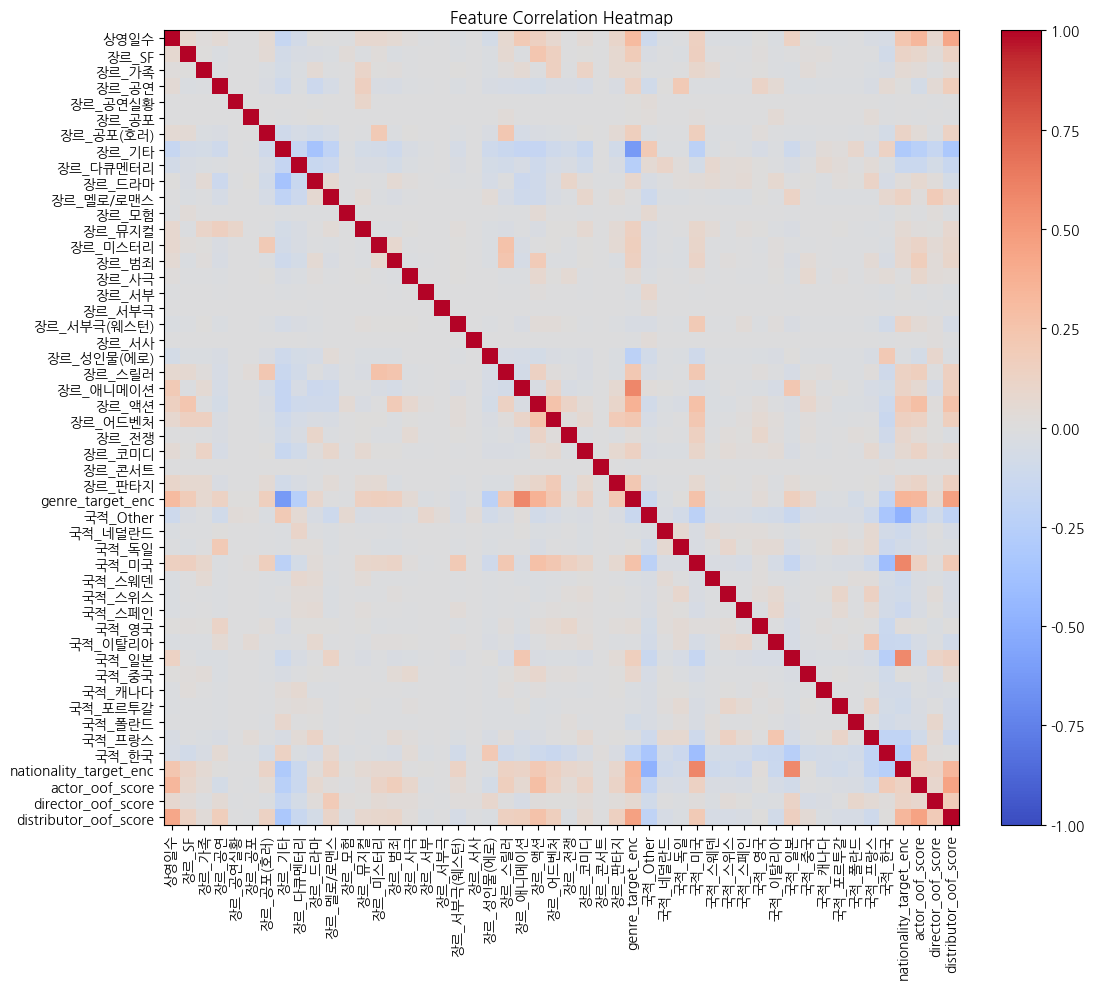

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 상관관계 행렬 계산 (숫자형 컬럼만 자동 포함)
corr_matrix = df.corr()

# 2) 히트맵 시각화
plt.figure(figsize=(12, 10))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)

cols = corr_matrix.columns.tolist()
plt.xticks(range(len(cols)), cols, rotation=90)
plt.yticks(range(len(cols)), cols)

plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()